In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
%pip install wandb
!wandb

Usage: wandb [OPTIONS] COMMAND [ARGS]...

Options:
  --version  Show the version and exit.
  --help     Show this message and exit.

Commands:
  agent         Run the W&B agent
  artifact      Commands for interacting with...
  controller    Run the W&B local sweep...
  disabled      Disable W&B.
  docker        W&B docker lets you run your...
  docker-run    Simple wrapper for `docker run`...
  enabled       Enable W&B.
  init          Configure a directory with...
  launch        Launch or queue a job from a
                uri...

  launch-agent  Run a W&B launch agent...
  local         Launch local W&B container...
  login         Login to Weights & Biases
  offline       Disable W&B sync
  online        Enable W&B sync
  pull          Pull files from Weights & Biases
  restore       Restore code, config and docker...
  status        Show configuration settings
  sweep         Create a sweep
  sync          Upload an offline training...
  verify        Verify your local instance


In [17]:
%pip install kaggle --upgrade
import os
fpath = os.path.join(os.path.expanduser("~"), ".kaggle", "kaggle.json")
if not os.path.isfile(fpath):
    try:
        os.mkdir(os.path.join(os.path.expanduser("~"), ".kaggle"))
    except Exception:
        pass
    with open(fpath, "w") as f:
        f.write(input(f"input {fpath}"))
    !chmod 600 {fpath}

In [18]:
if 'datasets' not in os.listdir(os.getcwd()) or 'animals10' not in os.listdir(os.path.join(os.getcwd(), 'datasets')):
    !kaggle datasets download alessiocorrado99/animals10
    !mkdir datasets
    !unzip animals10.zip -d datasets/animals10
    !rm animals10.zip

In [19]:
import torch.nn as nn
import torch.nn.functional as F
class someNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(IM_HEIGHT*IM_WIDTH*3, 100)
        self.l2 = nn.Linear(100, 10)
    def forward(self, x):
        x = self.l1(x)
        x = F.relu(x)
        x = self.l2(x)
        x = F.log_softmax(x)
        return x


In [20]:
from tqdm import tqdm
def train(model, dev, train_set_loader, optimizer, epoch, WAND, LOG_INTERVAL):
    model.train()
    for bI, (x_b, y_b) in enumerate(tqdm(train_set_loader)):
        x_b = review(x_b)
        x_b, y_b = preprocess(x_b, y_b)
        pred = model.forward(x_b)
        loss = loss_fn(pred, y_b)
        # clear gradients for this training step
        optimizer.zero_grad()
        # backprop, compute gradients
        loss.backward()
        # apply gradients
        optimizer.step()
        if bI % LOG_INTERVAL == 0:
            loss_final = loss.mean().item()
            if WAND: wandb.log({"train_loss": loss_final})
            print(epoch, loss_final)

def test(model, dev, test_set_loader, WAND):
    with torch.no_grad():
        val_loss = torch.Tensor(len(test_set_loader)).to(dev)
        for i, (x_v_b, y_v_b) in enumerate(tqdm(test_set_loader)):
            x_v_b, y_v_b = preprocess(x_v_b, y_v_b)
            x_v_b = review(x_v_b)
            pred = model.forward(x_v_b)
            loss = loss_fn(pred, y_v_b)
            val_loss[i] = (loss.sum()/y_v_b.shape[0])
        val_loss_final = val_loss.mean().item()
        if WAND: wandb.log({"val_loss": val_loss_final})
        print(val_loss_final)


In [21]:
WAND = True
LOG_INTERVAL = 10
N_EPOCH = 10
LR = 0.01
BS = 256
IM_HEIGHT = 425
IM_WIDTH = 600
TRAIN_DAT_PERC = 0.95

In [22]:
if WAND:
  import wandb
  wandb_run = wandb.init(project="animals10", entity="0xasim")
  wandb.config = {
    "learning_rate": LR,
    "epochs": N_EPOCH,
    "batch_size": BS
  }
  run_name = wandb_run.name

In [24]:
import torch
import os
# torch.manual_seed(17)
from torchvision import datasets, transforms
transform = transforms.Compose([transforms.Resize([IM_HEIGHT, IM_WIDTH]), transforms.ToTensor()])
path = os.path.join(os.getcwd(), "datasets", "animals10", "raw-img")
dataset = datasets.ImageFolder(path, transform=transform)
train_set, test_set = torch.utils.data.random_split(dataset, [int(len(dataset)*TRAIN_DAT_PERC), int(len(dataset)*round(1-TRAIN_DAT_PERC, 2))+1])
train_set_loader = torch.utils.data.DataLoader(train_set, batch_size=BS, shuffle=True)
test_set_loader = torch.utils.data.DataLoader(test_set, batch_size=BS, shuffle=True)

torch.Size([256, 3, 425, 600]) torch.Size([3, 425, 600])
tensor([[0.5216, 0.5176, 0.5098,  ..., 0.6471, 0.6471, 0.6471],
        [0.5255, 0.5216, 0.5137,  ..., 0.6471, 0.6471, 0.6471],
        [0.5333, 0.5294, 0.5216,  ..., 0.6431, 0.6431, 0.6431],
        ...,
        [0.6667, 0.6706, 0.6784,  ..., 0.4941, 0.4863, 0.4824],
        [0.6745, 0.6784, 0.6863,  ..., 0.4941, 0.4902, 0.4863],
        [0.6745, 0.6784, 0.6902,  ..., 0.4941, 0.4902, 0.4863]])


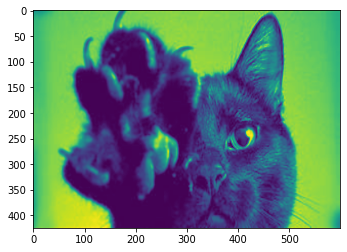

tensor([[0.5176, 0.5137, 0.5059,  ..., 0.6510, 0.6510, 0.6510],
        [0.5216, 0.5176, 0.5098,  ..., 0.6510, 0.6510, 0.6510],
        [0.5294, 0.5255, 0.5176,  ..., 0.6471, 0.6471, 0.6471],
        ...,
        [0.6824, 0.6863, 0.6941,  ..., 0.4980, 0.4902, 0.4863],
        [0.6902, 0.6941, 0.7020,  ..., 0.4980, 0.4941, 0.4902],
        [0.6902, 0.6941, 0.7059,  ..., 0.4980, 0.4941, 0.4902]])
tensor(0.)
tensor(1.)


In [25]:
import matplotlib.pyplot as plt
i, l = next(iter(train_set_loader))
print(i.shape, i[0].shape)
sample = i[0][2]
print(sample)
plt.imshow(i[0][2].reshape(IM_HEIGHT, IM_WIDTH))
plt.show()
print(i[0][0])
print(torch.min(i[0][0]))
print(torch.max(i[0][0]))

In [26]:
def preprocess(x, y):
    return x.to(dev), y.to(dev)
review = lambda x_b: x_b.view(len(x_b), -1)

if __name__ == '__main__':
    dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    print(dev)
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    model = someNet()
    model.to(dev)
    loss_fn = nn.CrossEntropyLoss().to(dev)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    for epoch in range(N_EPOCH):
        train(model, dev, train_set_loader, optimizer, epoch, WAND, LOG_INTERVAL)
        test(model, dev, test_set_loader, WAND)

cuda


  0%|          | 0/98 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
  1%|          | 1/98 [00:03<05:51,  3.63s/it]

0 2.3203186988830566


  2%|▏         | 2/98 [00:08<06:59,  4.37s/it]


KeyboardInterrupt: ignored

In [ ]:
model_name = run_name+'.pt'
MODEL_PATH = os.path.join(os.getcwd(), str(N_EPOCH))
torch.save(model.state_dict(), model_name)
print(model_name)
!ls -lah {model_name}

In [ ]:
INCOLAB = 'google.colab' in str(get_ipython()) if hasattr(__builtins__,'__IPYTHON__') else False
DOWNLOAD = True
if INCOLAB and DOWNLOAD:
    from google.colab import files
    files.download(model_name)